In [1]:
import matplotlib.pyplot as plt
import numpy as np
import librosa.display
import librosa.feature
import IPython.display as ipd
import math

# Basic audio features

- Code copied from: https://github.com/musikalkemist/AudioSignalProcessingForML
- Accompanying videos: https://www.youtube.com/watch?v=iCwMQJnKk2c&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&ab_channel=ValerioVelardo-TheSoundofAI

## Loading audio files

In [2]:
normal_file = "assets/heart_sounds/01_apex_normal_s1_s2_supine_bell.mp3"
s2_split_file = "assets/heart_sounds/19_pulm_spilt_s2_persistent_supine_diaph.mp3"
s3_file = "assets/heart_sounds/05_apex_s3_lld_bell.mp3"
mid_syst_murmur_file = "assets/heart_sounds/07_apex_mid_sys_mur_supine_bell.mp3"

In [3]:
ipd.Audio(normal_file)

In [4]:
ipd.Audio(s2_split_file)

In [5]:
ipd.Audio(s3_file)

In [6]:
ipd.Audio(mid_syst_murmur_file)

In [7]:
DURATION = 2.0 # seconds
OFFSET = 1.0 # seconds

# load audio files with librosa
normal, sr = librosa.load(normal_file, offset = OFFSET, duration = DURATION)
s2_split, sr = librosa.load(s2_split_file, offset = OFFSET, duration = DURATION)
s3, sr = librosa.load(s3_file, offset = OFFSET, duration = DURATION)
mid_syst_murmur, sr = librosa.load(mid_syst_murmur_file, offset = OFFSET, duration = DURATION)
sr

22050

In [8]:
# We normalize the signals
normal = librosa.util.normalize(normal)
s2_split = librosa.util.normalize(s2_split)
s3 = librosa.util.normalize(s3)
mid_syst_murmur = librosa.util.normalize(mid_syst_murmur)

## Basic information regarding audio files

In [9]:
# duration of debussy audio in seconds
tot_samples = len(normal)
duration = 1 / sr * tot_samples
print(f"The audio lasts for {duration} seconds")

The audio lasts for 2.0 seconds


## Amplitude envelope, RMS energy, and ZCR

In [10]:
FRAME_SIZE = 1024
HOP_LENGTH = 512

In [11]:
def amplitude_envelope(signal, frame_size, hop_length):
    """Fancier Python code to calculate the amplitude envelope of a signal with a given frame size."""
    return np.array([max(signal[i:i+frame_size]) for i in range(0, len(signal), hop_length)])

In [12]:
# Computing amplitude envelop
ae_normal = amplitude_envelope(normal, FRAME_SIZE, HOP_LENGTH)
ae_s2_split = amplitude_envelope(s2_split, FRAME_SIZE, HOP_LENGTH)
ae_s3 = amplitude_envelope(s3, FRAME_SIZE, HOP_LENGTH)
ae_mid_syst_murmur = amplitude_envelope(mid_syst_murmur, FRAME_SIZE, HOP_LENGTH)

In [13]:
# Computing RMS energy
rms_normal = librosa.feature.rms(y=normal, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
rms_s2_split = librosa.feature.rms(y=s2_split, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
rms_s3 = librosa.feature.rms(y=s3, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
rms_mid_syst_murmur = librosa.feature.rms(y=mid_syst_murmur, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

In [14]:
# Computing ZCR
zcr_normal = librosa.feature.zero_crossing_rate(y=normal, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
zcr_s2_split = librosa.feature.zero_crossing_rate(y=s2_split, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
zcr_s3 = librosa.feature.zero_crossing_rate(y=s3, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
zcr_mid_syst_murmur = librosa.feature.zero_crossing_rate(y=mid_syst_murmur, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

In [15]:
frames = range(len(ae_normal))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)
# Not sure why we need to offset a whole step.
# I would have expected half a step to be ok, but it is not enough.
t_mod = t + t[1]
#t = t + t[1] / 2.0

In [16]:
# Scaling constant to see ZCR better
zcr_scaling = 20

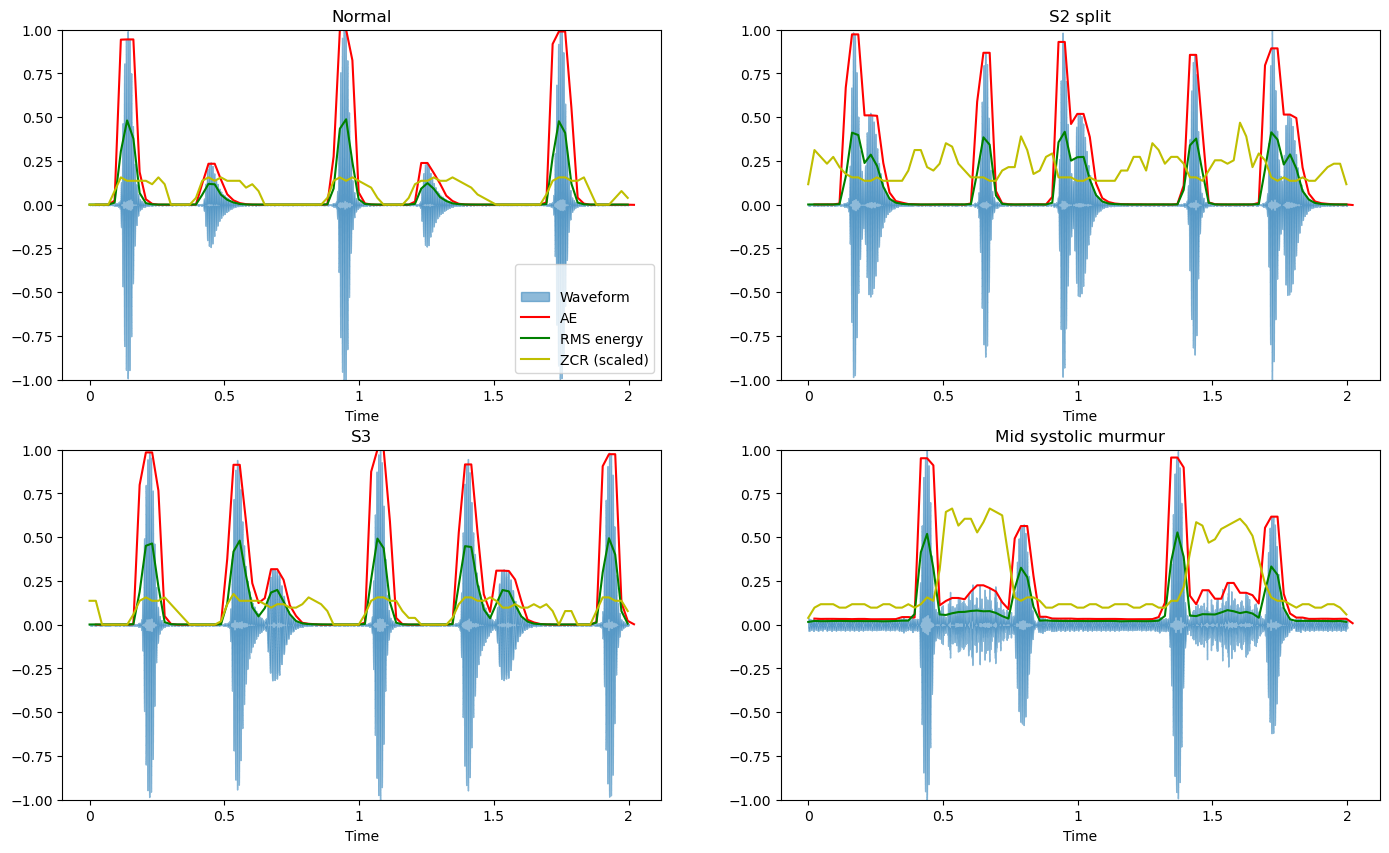

In [17]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 2, 1)
librosa.display.waveshow(normal, alpha=0.5)
plt.plot(t_mod, ae_normal, color="r")
plt.plot(t, rms_normal, color="g")
plt.plot(t, zcr_normal * zcr_scaling, color="y")
plt.ylim((-1, 1))
plt.title("Normal")
plt.legend(["", "Waveform", "AE", "RMS energy", "ZCR (scaled)"])

plt.subplot(2, 2, 2)
librosa.display.waveshow(s2_split, alpha=0.5)
plt.plot(t_mod, ae_s2_split, color="r")
plt.plot(t, rms_s2_split, color="g")
plt.plot(t, zcr_s2_split * zcr_scaling, color="y")
plt.ylim((-1, 1))
plt.title("S2 split")

plt.subplot(2, 2, 3)
librosa.display.waveshow(s3, alpha=0.5)
plt.plot(t_mod, ae_s3, color="r")
plt.plot(t, rms_s3, color="g")
plt.plot(t, zcr_s3 * zcr_scaling, color="y")
plt.ylim((-1, 1))
plt.title("S3")

plt.subplot(2, 2, 4)
librosa.display.waveshow(mid_syst_murmur, alpha=0.5)
plt.plot(t_mod, ae_mid_syst_murmur, color="r")
plt.plot(t, rms_mid_syst_murmur, color="g")
plt.plot(t, zcr_mid_syst_murmur * zcr_scaling, color="y")
plt.ylim((-1, 1))
plt.title("Mid systolic murmur")

plt.show()

Note: RMS energy is more resilient to outliers

## FFT

In [18]:
# We resample in order to get a reasonable amount of bins (n_bins = n_samples)
low_sr = 2048
# Note that an antialiasing filter is automatically applied
normal_resampled = librosa.resample(normal, orig_sr=sr, target_sr=low_sr)
s2_split_resampled = librosa.resample(s2_split, orig_sr=sr, target_sr=low_sr)
s3_resampled = librosa.resample(s3, orig_sr=sr, target_sr=low_sr)
mid_syst_murmur_resampled = librosa.resample(mid_syst_murmur, orig_sr=sr, target_sr=low_sr)

In [19]:
# f_ratio is the ratio of frequency we want to display.
# Use 0.5 to stop of the Nyquist frequency.
f_ratio = 0.5

fft_normal_resampled = np.absolute(np.fft.fft(normal_resampled))
fft_s2_split_resampled = np.absolute(np.fft.fft(s2_split_resampled))
fft_s3_resampled = np.absolute(np.fft.fft(s3_resampled))
fft_mid_syst_murmur_resampled = np.absolute(np.fft.fft(mid_syst_murmur_resampled))

frequencies = np.linspace(0, low_sr, len(fft_normal_resampled))
f_bins = int(len(fft_normal_resampled)*f_ratio)
frequencies.shape


(4096,)

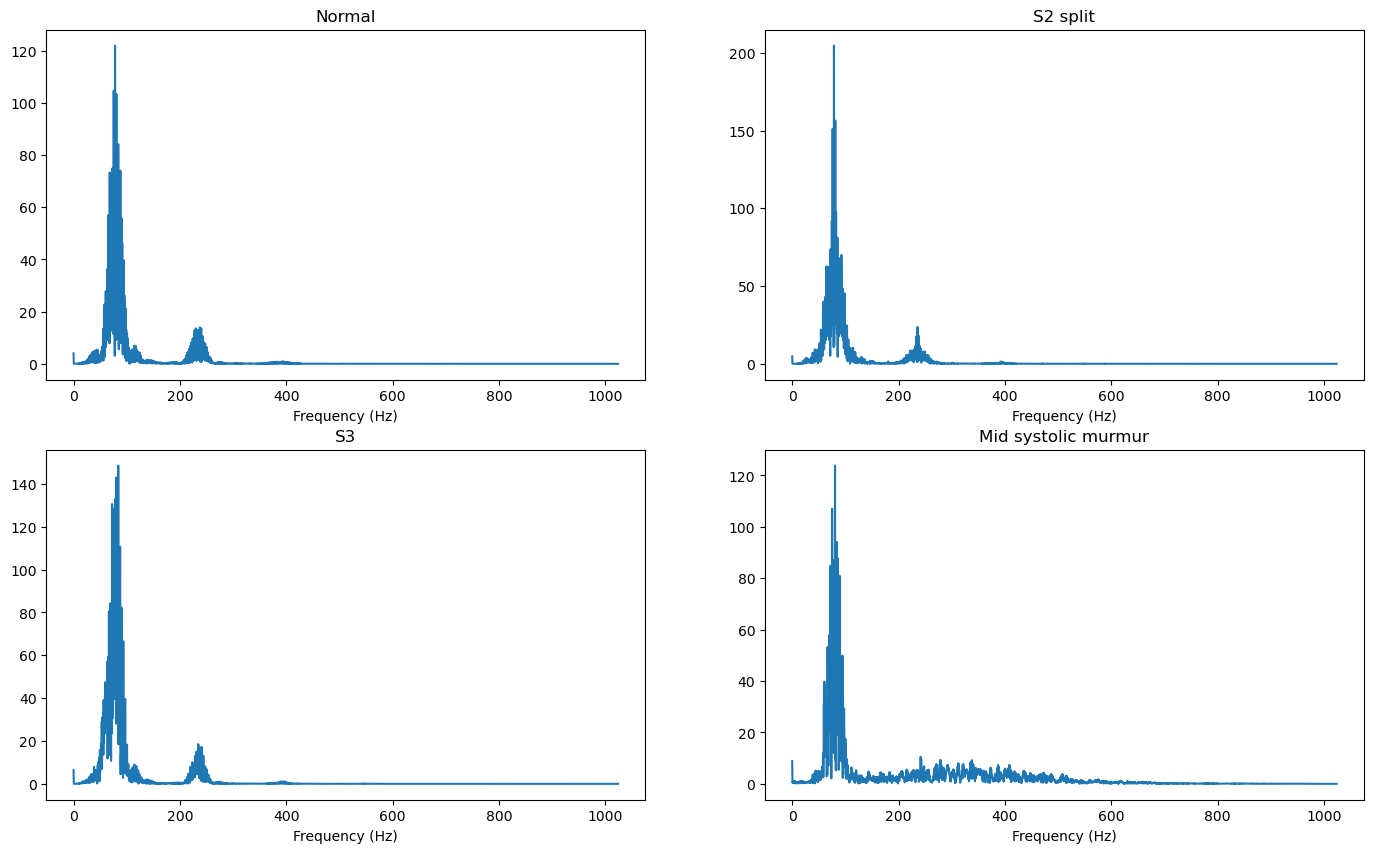

In [20]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 2, 1)
plt.plot(frequencies[:f_bins], fft_normal_resampled[:f_bins])
plt.xlabel('Frequency (Hz)')
plt.title("Normal")

plt.subplot(2, 2, 2)
plt.plot(frequencies[:f_bins], fft_s2_split_resampled[:f_bins])
plt.xlabel('Frequency (Hz)')
plt.title("S2 split")

plt.subplot(2, 2, 3)
plt.plot(frequencies[:f_bins], fft_s3_resampled[:f_bins])
plt.xlabel('Frequency (Hz)')
plt.title("S3")

plt.subplot(2, 2, 4)
plt.plot(frequencies[:f_bins], fft_mid_syst_murmur_resampled[:f_bins])
plt.xlabel('Frequency (Hz)')
plt.title("Mid systolic murmur")

plt.show()

## STFT

In [21]:
def plot_spectrogram(data, title, rate, y_axis="log"):
    stft = librosa.stft(data, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
    stft_power = np.abs(stft) ** 2
    stft_powerlog = librosa.power_to_db(stft_power)


    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(25, 10))
    librosa.display.waveshow(data, sr= rate, ax=ax1)
    img = librosa.display.specshow(stft_powerlog,
                             sr=rate,
                             hop_length=HOP_LENGTH,
                             x_axis="time",
                             y_axis=y_axis,
                             cmap='inferno',
                             ax=ax2)
    #fig.colorbar(img, ax=ax2, format='%+2.0f dB')
    fig.suptitle(title)

    plt.show()

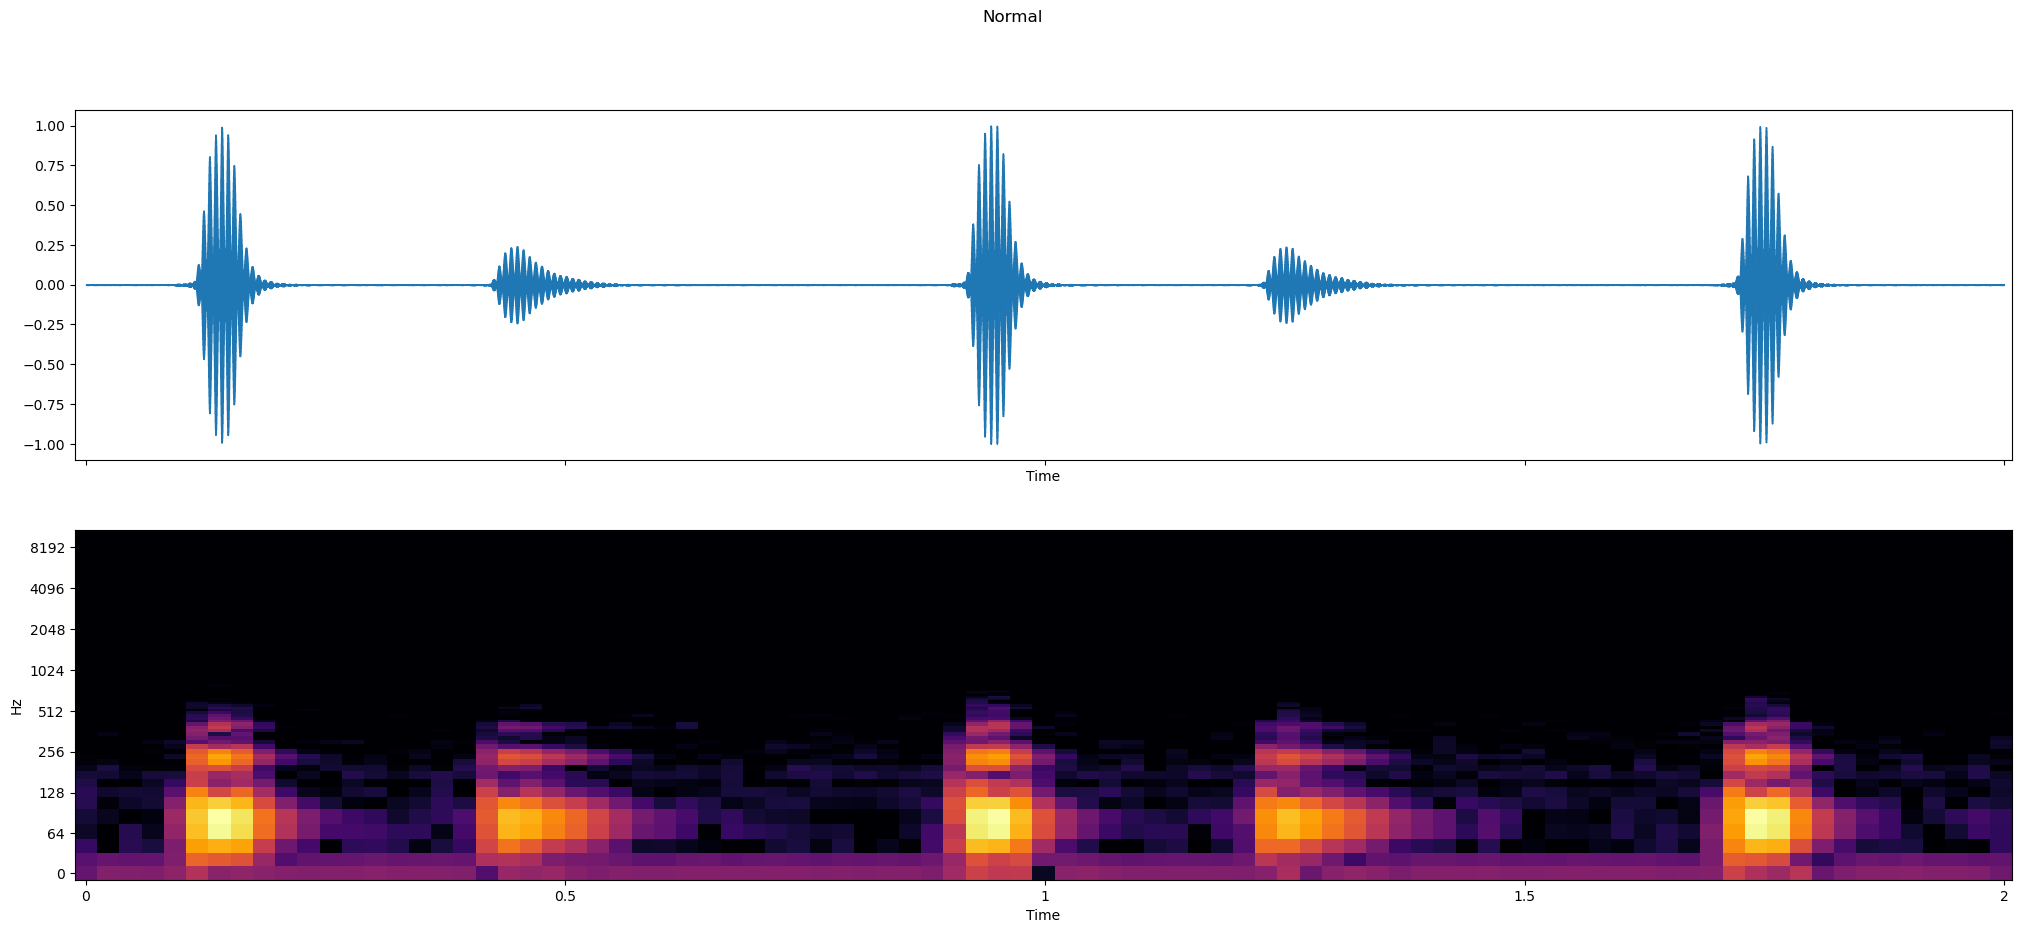

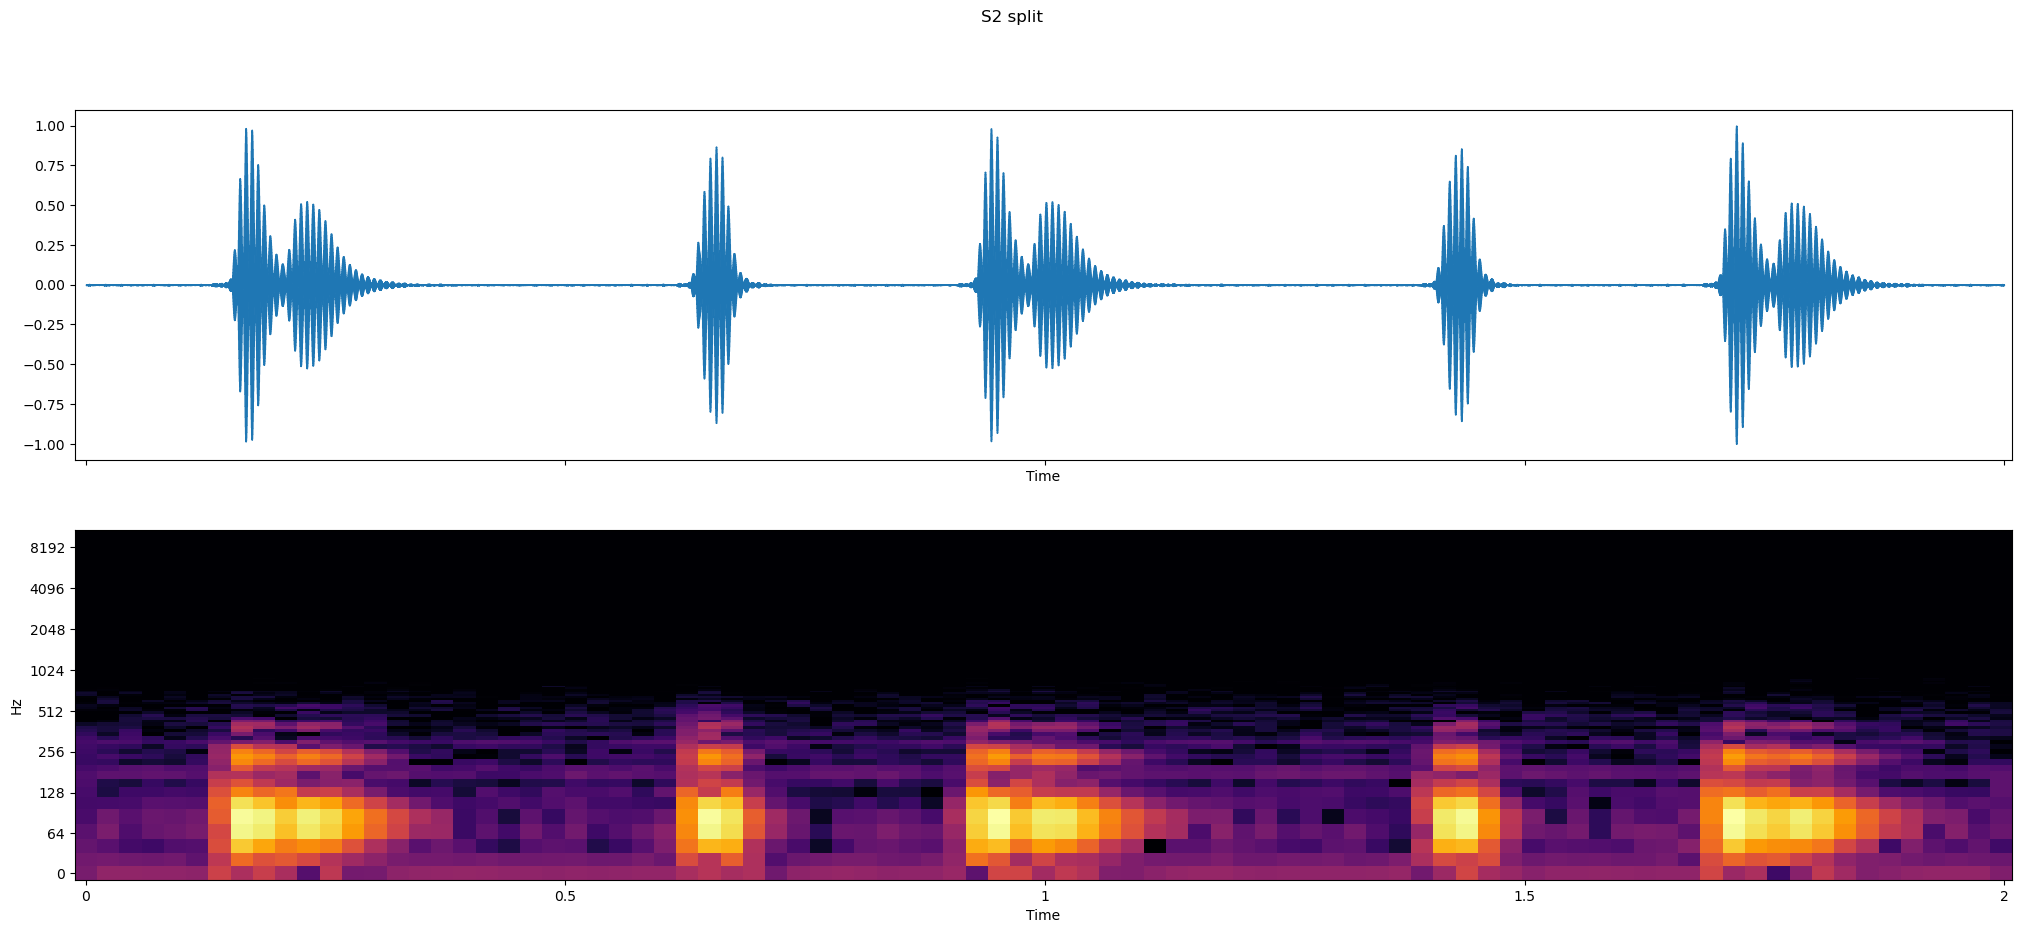

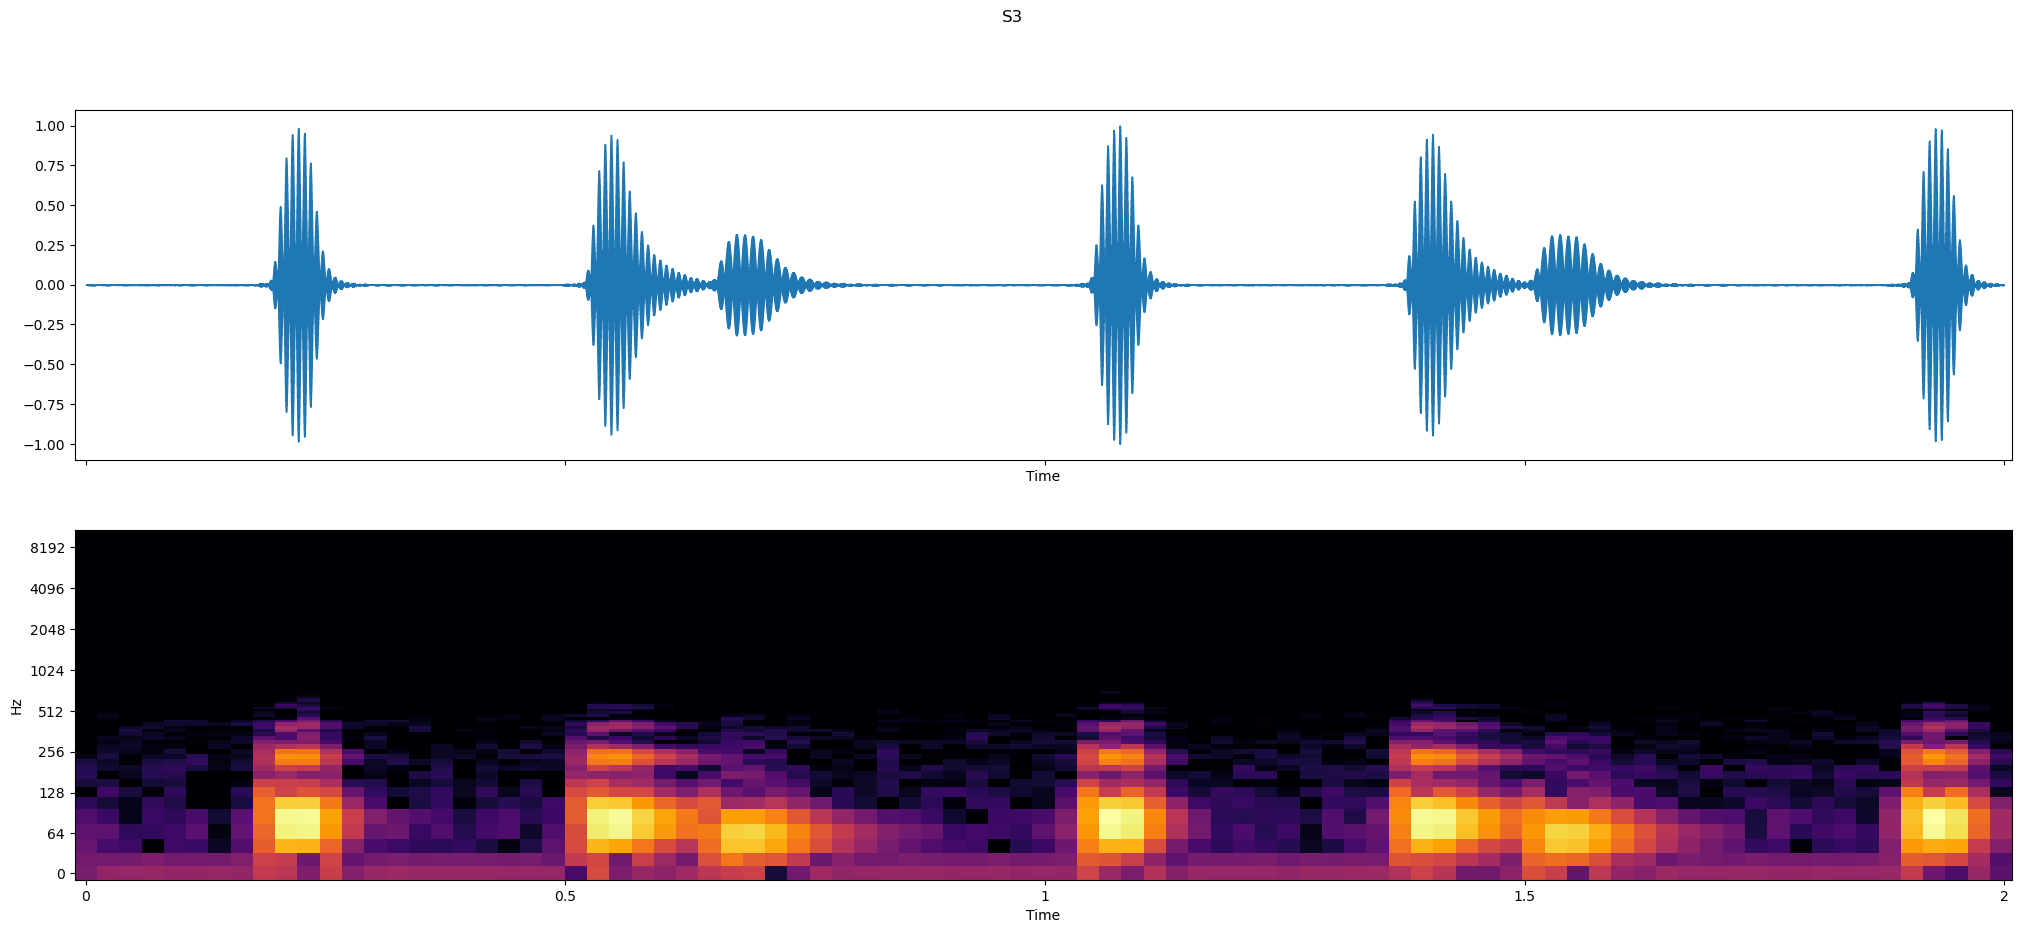

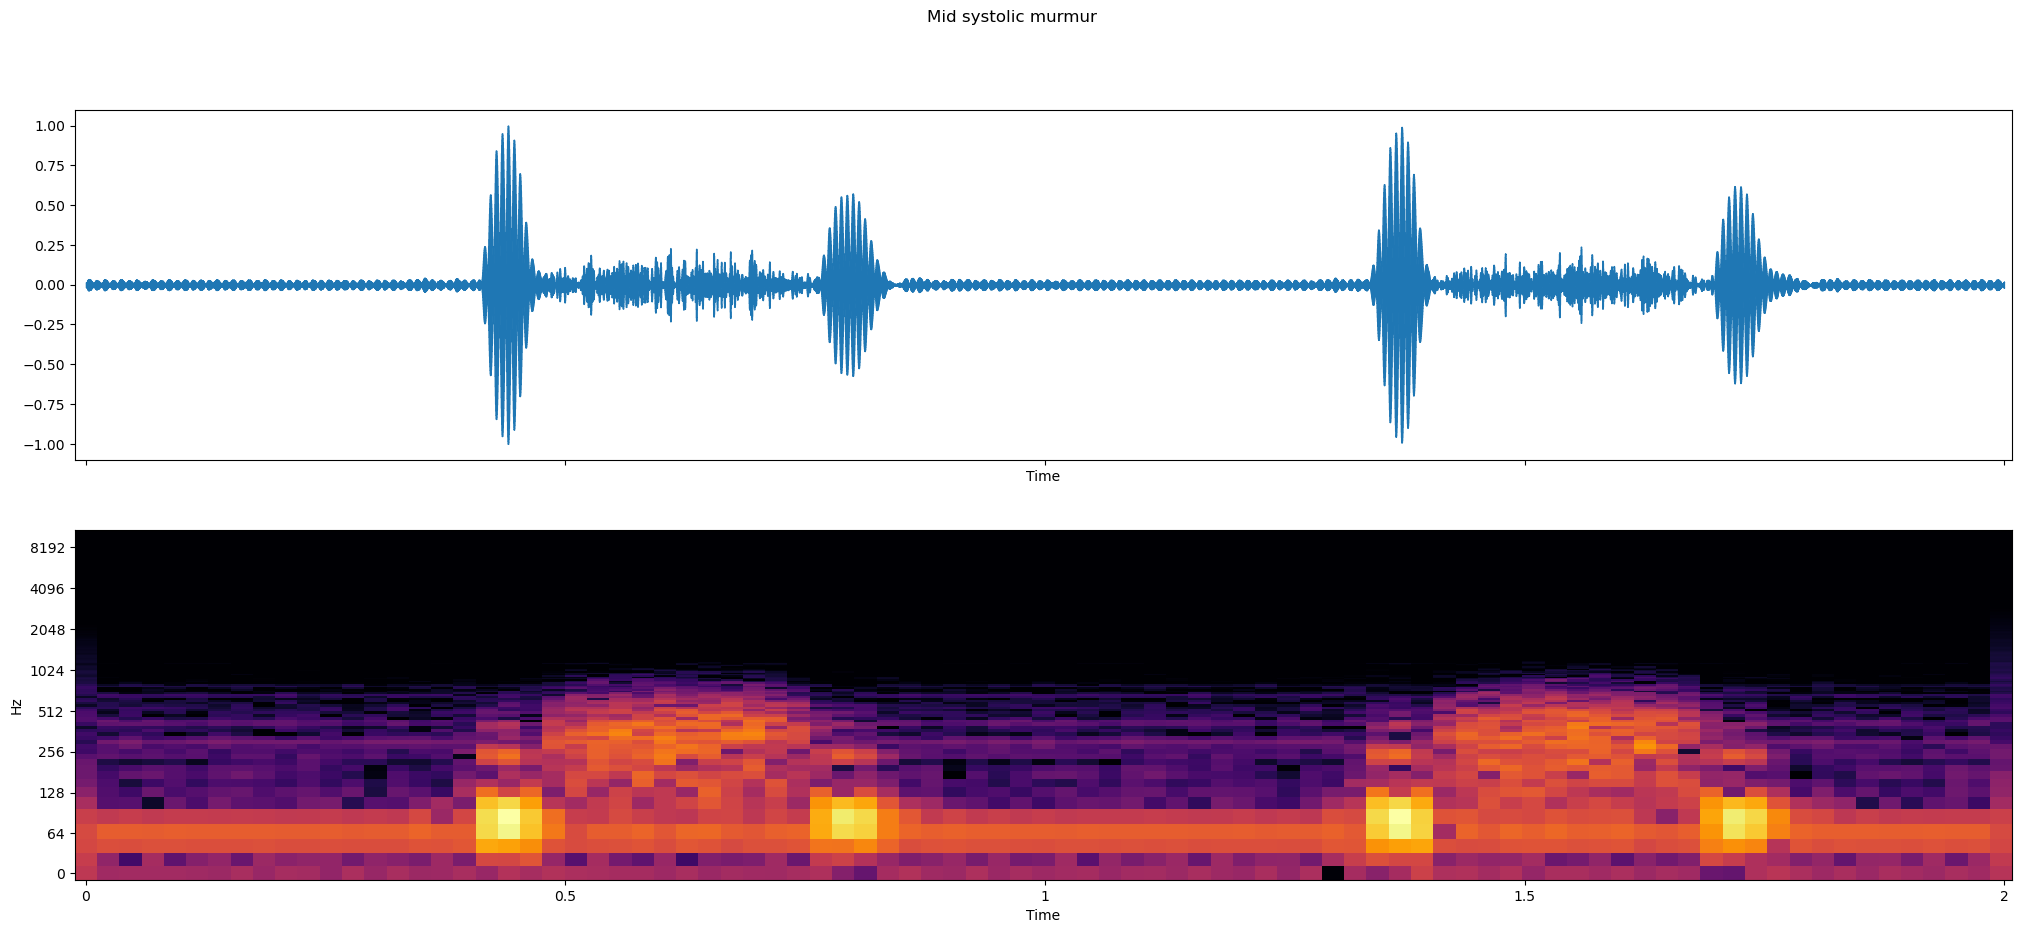

In [22]:
plot_spectrogram(normal, "Normal", sr)
plot_spectrogram(s2_split, "S2 split", sr)
plot_spectrogram(s3, "S3", sr)
plot_spectrogram(mid_syst_murmur, "Mid systolic murmur", sr)

In [23]:
stft = librosa.stft(normal, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
stft.shape

(513, 87)

### Band energy ratio

In [35]:
CUTOFF_FREQ = 1024

In [36]:
def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""

    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [37]:
def band_energy_ratio(data, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""

    spectrogram = librosa.stft(data, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []

    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T

    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / sum_power_high_frequencies
        band_energy_ratio.append(band_energy_ratio_current_frame)

    return np.array(band_energy_ratio)

In [38]:
ber_normal = band_energy_ratio(normal, CUTOFF_FREQ, sr)
ber_s2_split = band_energy_ratio(s2_split, CUTOFF_FREQ, sr)
ber_s3 = band_energy_ratio(s3, CUTOFF_FREQ, sr)
ber_mid_syst_murmur = band_energy_ratio(mid_syst_murmur, CUTOFF_FREQ, sr)

In [39]:
frames = range(len(ber_normal))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

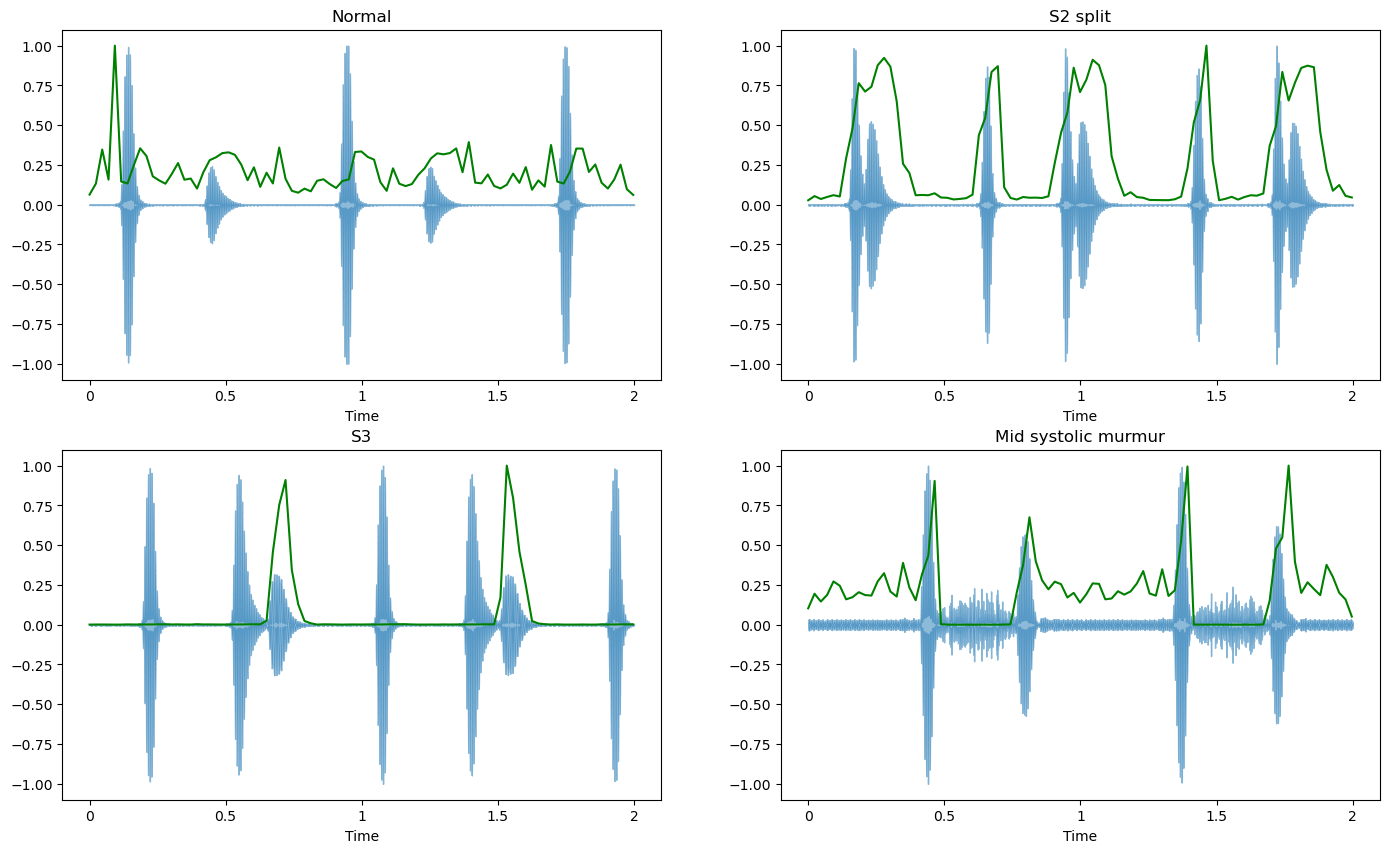

In [40]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 2, 1)
librosa.display.waveshow(normal, alpha=0.5)
plt.plot(t, ber_normal / max(ber_normal), color="g")
plt.title("Normal")

plt.subplot(2, 2, 2)
librosa.display.waveshow(s2_split, alpha=0.5)
plt.plot(t, ber_s2_split / max(ber_s2_split), color="g")
plt.title("S2 split")

plt.subplot(2, 2, 3)
librosa.display.waveshow(s3, alpha=0.5)
plt.plot(t, ber_s3 / max(ber_s3), color="g")
plt.title("S3")

plt.subplot(2, 2, 4)
librosa.display.waveshow(mid_syst_murmur, alpha=0.5)
plt.plot(t, ber_mid_syst_murmur / max(ber_mid_syst_murmur), color="g")
plt.title("Mid systolic murmur")

plt.show()

In [51]:
ber_normal_200 = band_energy_ratio(normal, 200, sr)
ber_normal_400 = band_energy_ratio(normal, 400, sr)
ber_normal_600 = band_energy_ratio(normal, 600, sr)

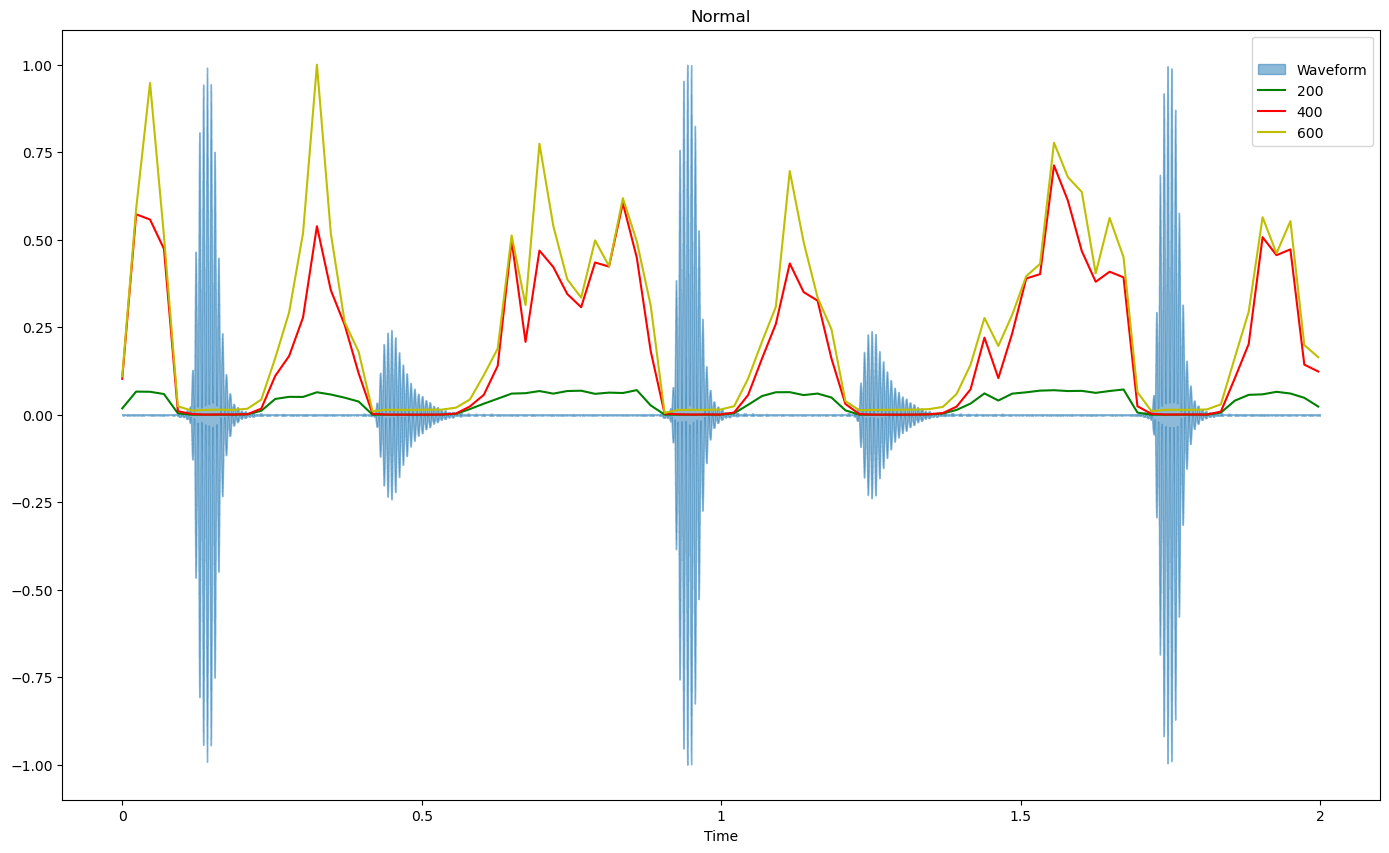

In [52]:
plt.figure(figsize=(17, 10))

librosa.display.waveshow(normal, alpha=0.5)
plt.plot(t, ber_normal_200 / max(ber_normal_600), color="g")
plt.plot(t, ber_normal_400 / max(ber_normal_600), color="r")
plt.plot(t, ber_normal_600 / max(ber_normal_600), color="y")
plt.legend(["", "Waveform", "200", "400", "600"])
plt.title("Normal")

plt.show()

### Spectral centroid

In [54]:
sc_normal = librosa.feature.spectral_centroid(y=normal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
sc_s2_split = librosa.feature.spectral_centroid(y=s2_split, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
sc_s3 = librosa.feature.spectral_centroid(y=s3, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
sc_mid_syst_murmur = librosa.feature.spectral_centroid(y=mid_syst_murmur, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

In [55]:
frames = range(len(sc_normal))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

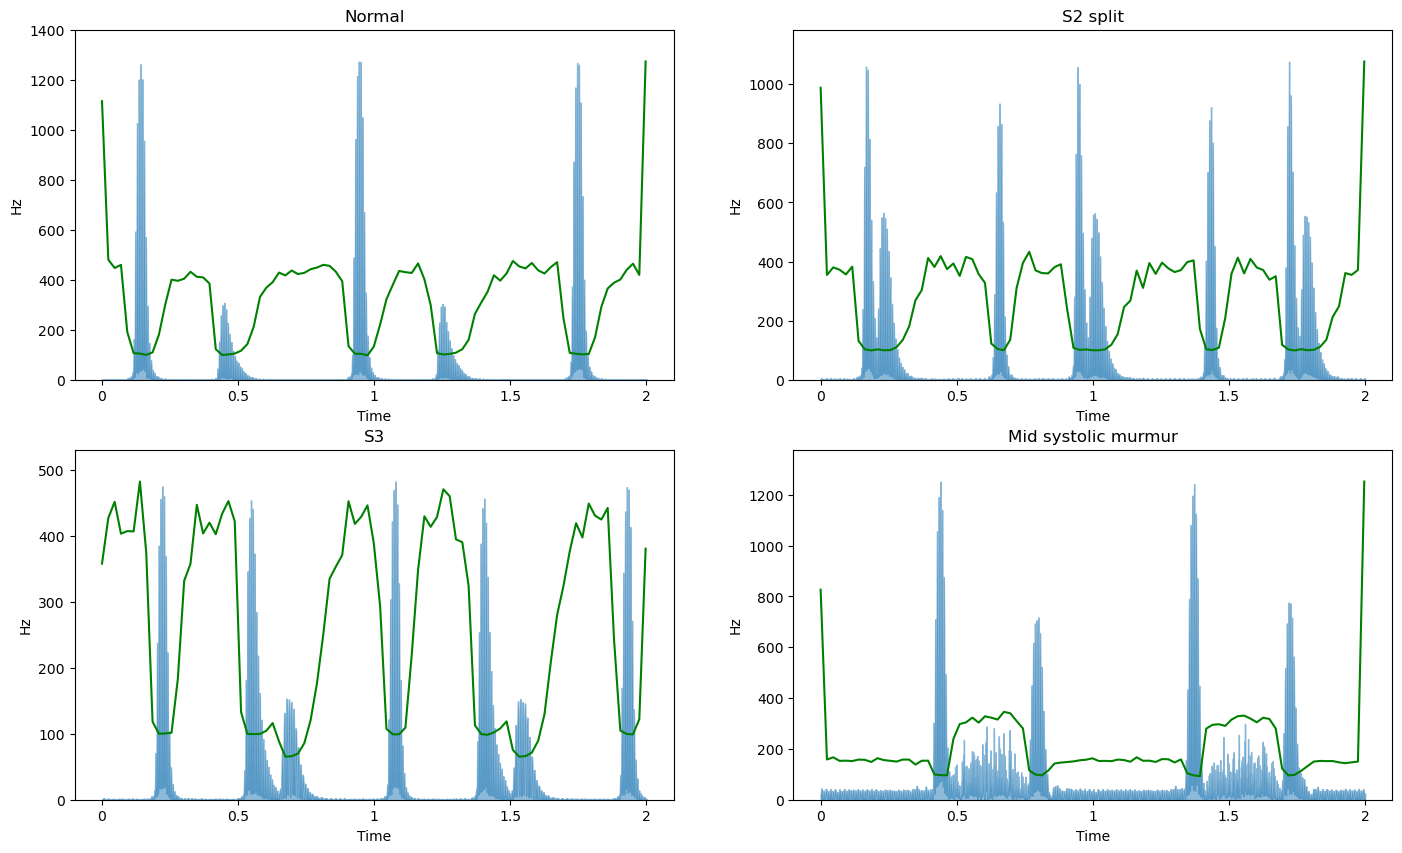

In [59]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 2, 1)
librosa.display.waveshow(normal * max(sc_normal), alpha=0.5)
plt.plot(t, sc_normal, color="g")
plt.ylabel("Hz")
plt.ylim(0, None)
plt.title("Normal")

plt.subplot(2, 2, 2)
librosa.display.waveshow(s2_split * max(sc_s2_split), alpha=0.5)
plt.plot(t, sc_s2_split, color="g")
plt.ylabel("Hz")
plt.ylim(0, None)
plt.title("S2 split")

plt.subplot(2, 2, 3)
librosa.display.waveshow(s3 * max(sc_s3), alpha=0.5)
plt.plot(t, sc_s3, color="g")
plt.ylabel("Hz")
plt.ylim(0, None)
plt.title("S3")

plt.subplot(2, 2, 4)
librosa.display.waveshow(mid_syst_murmur * max(sc_mid_syst_murmur), alpha=0.5)
plt.plot(t, sc_mid_syst_murmur, color="g")
plt.ylabel("Hz")
plt.ylim(0, None)
plt.title("Mid systolic murmur")

plt.show()

a## Mel spectrogram

In [30]:
def plot_mel_spectrogram(data, title, rate):
    mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=rate, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, n_mels=10)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)


    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(25, 10))
    librosa.display.waveshow(data, sr= rate, ax=ax1)
    img = librosa.display.specshow(log_mel_spectrogram,
                             sr=rate,
                             hop_length=HOP_LENGTH,
                             x_axis="time",
                             y_axis="mel",
                             cmap='inferno',
                             ax=ax2)
    #fig.colorbar(img, ax=ax2, format='%+2.0f dB')
    fig.suptitle(title)

    plt.show()

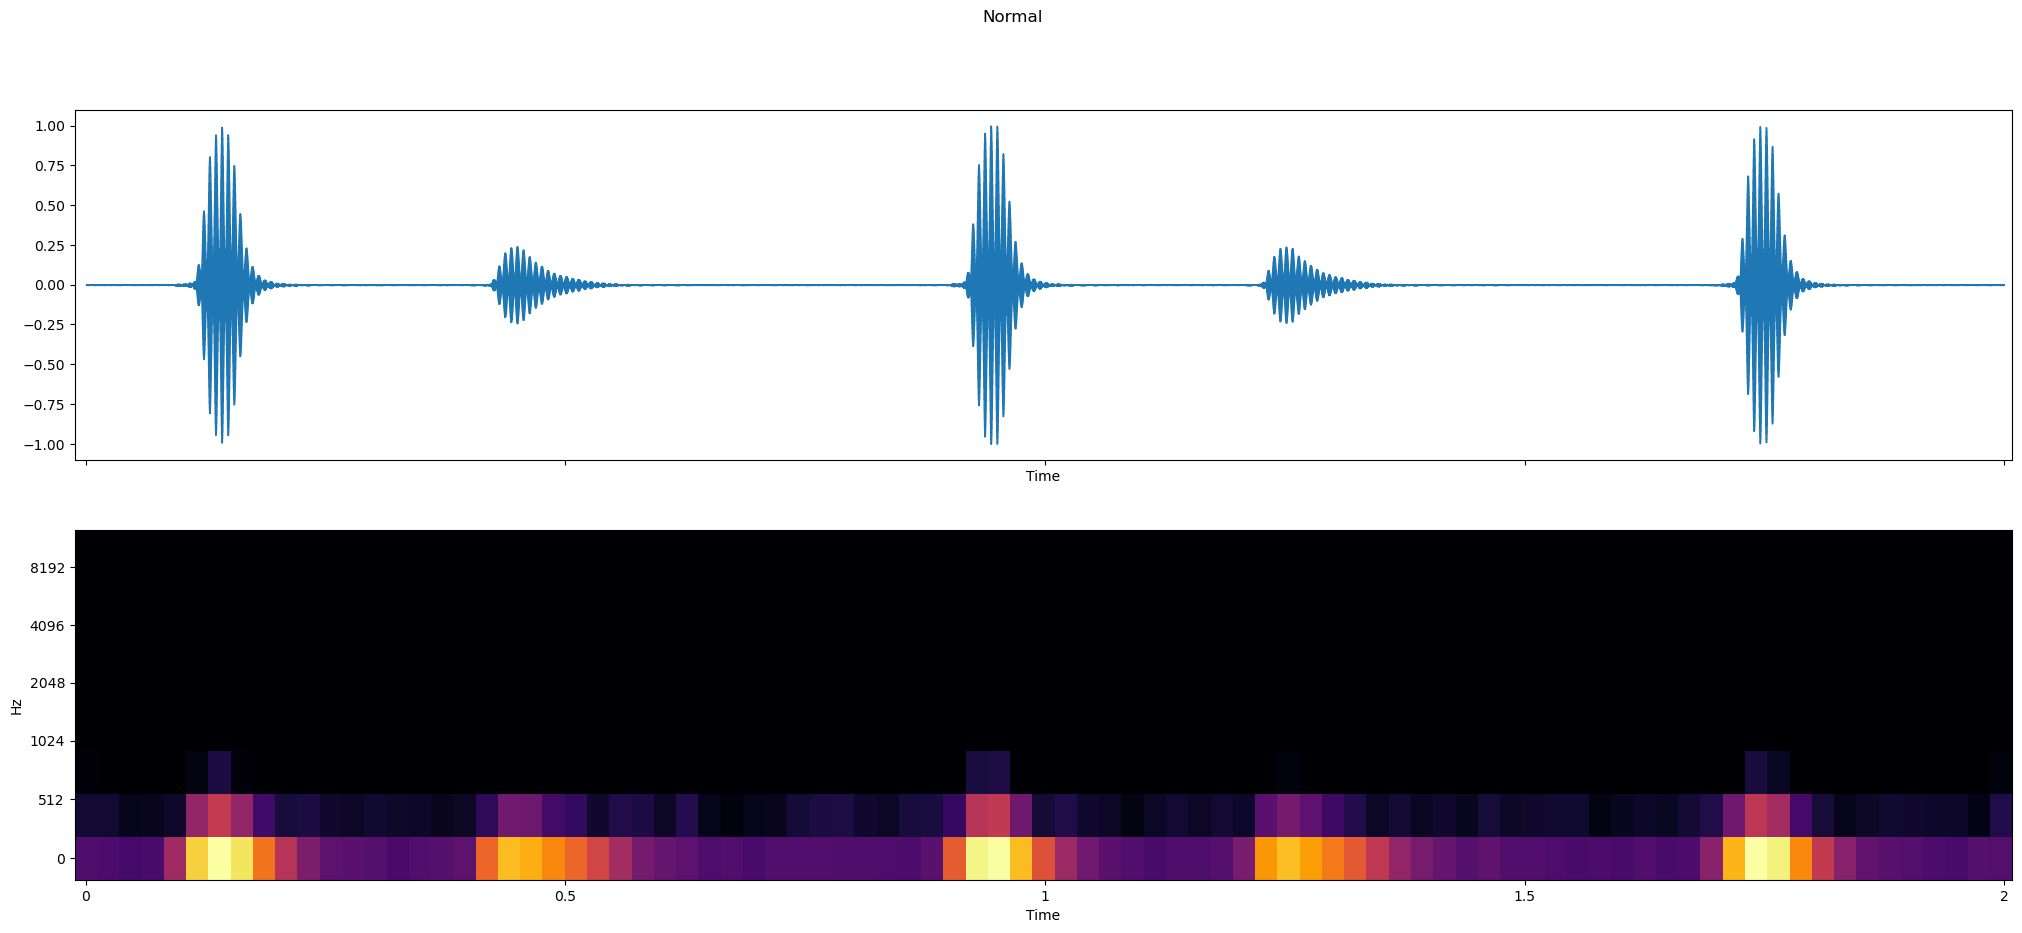

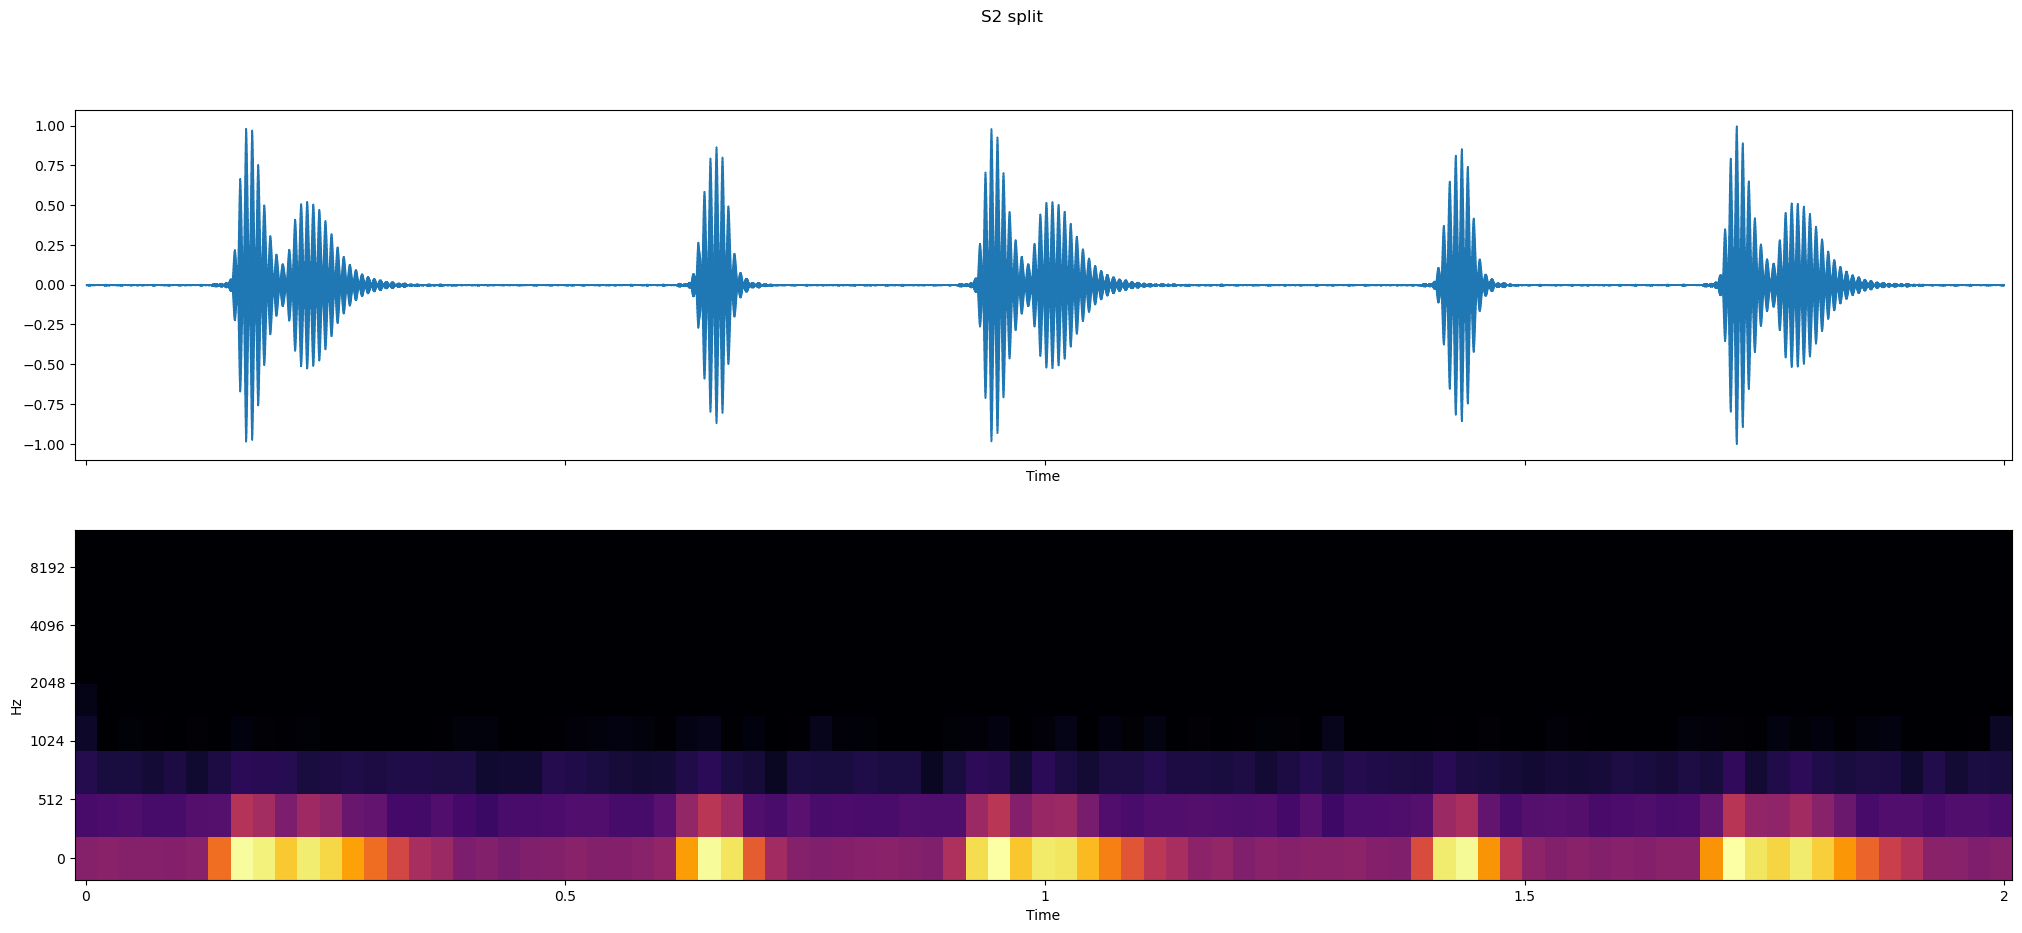

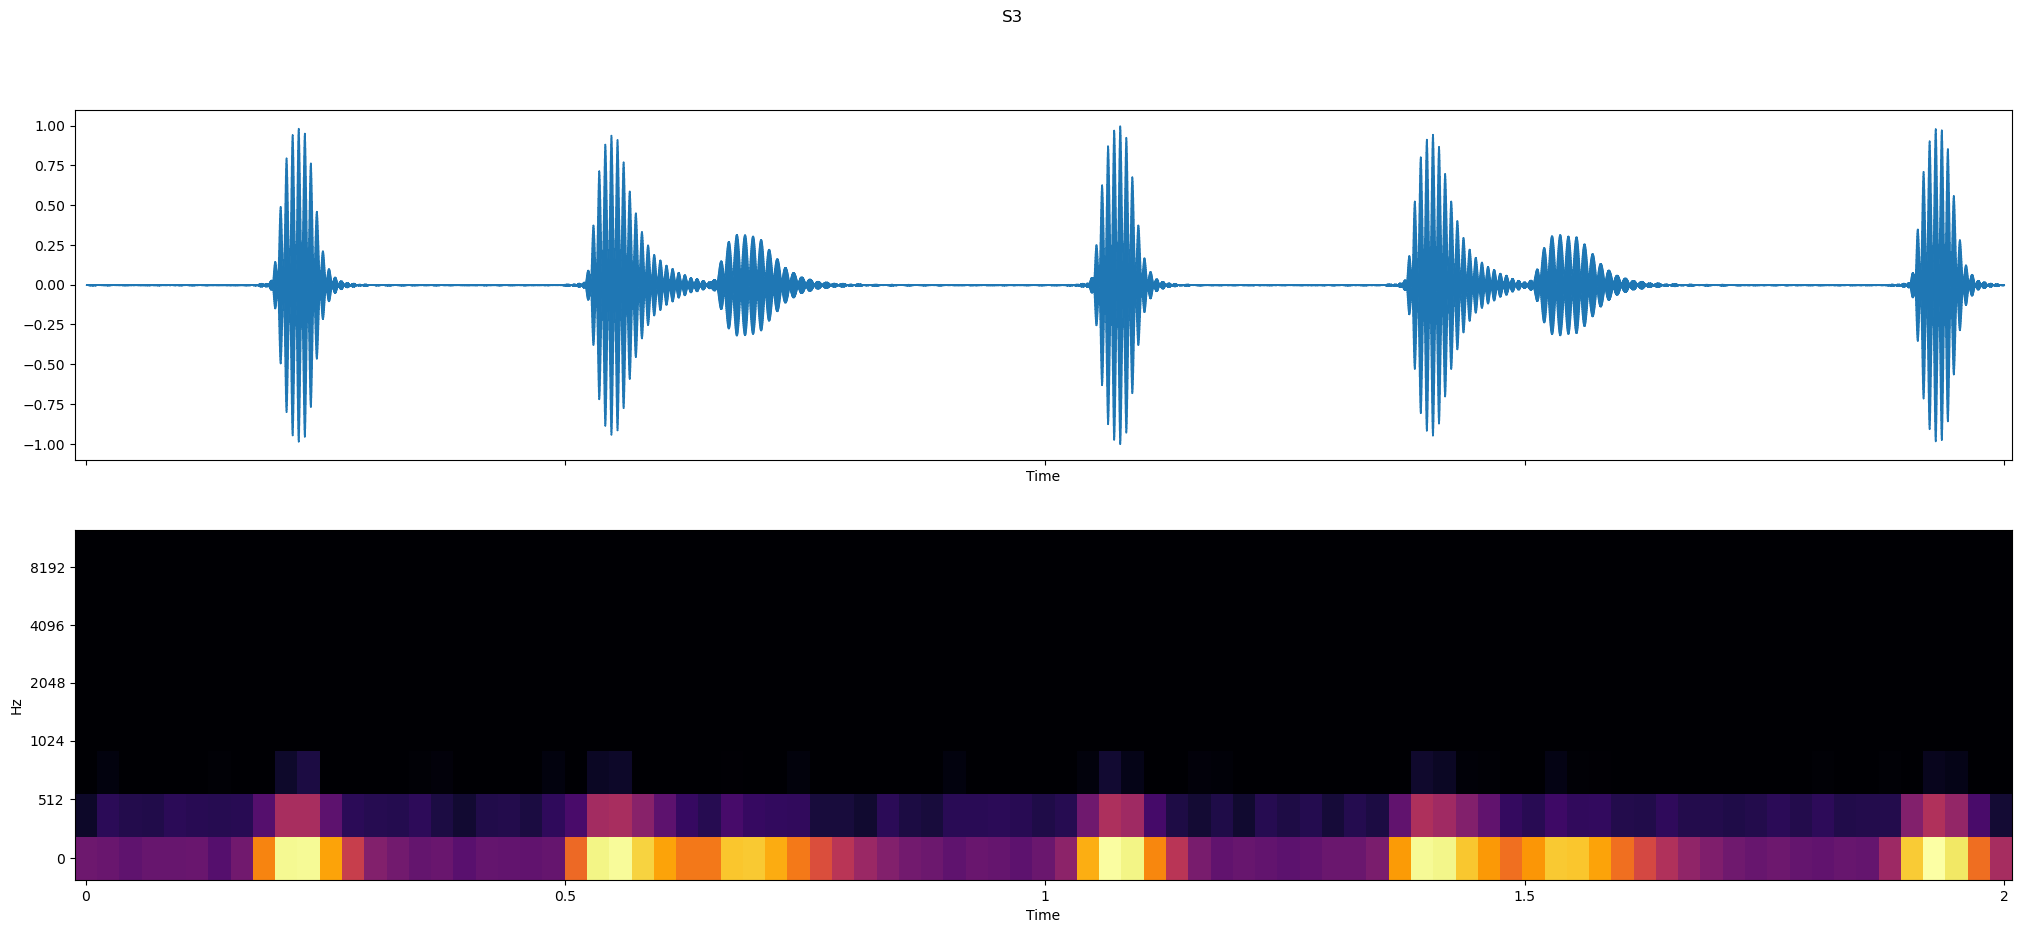

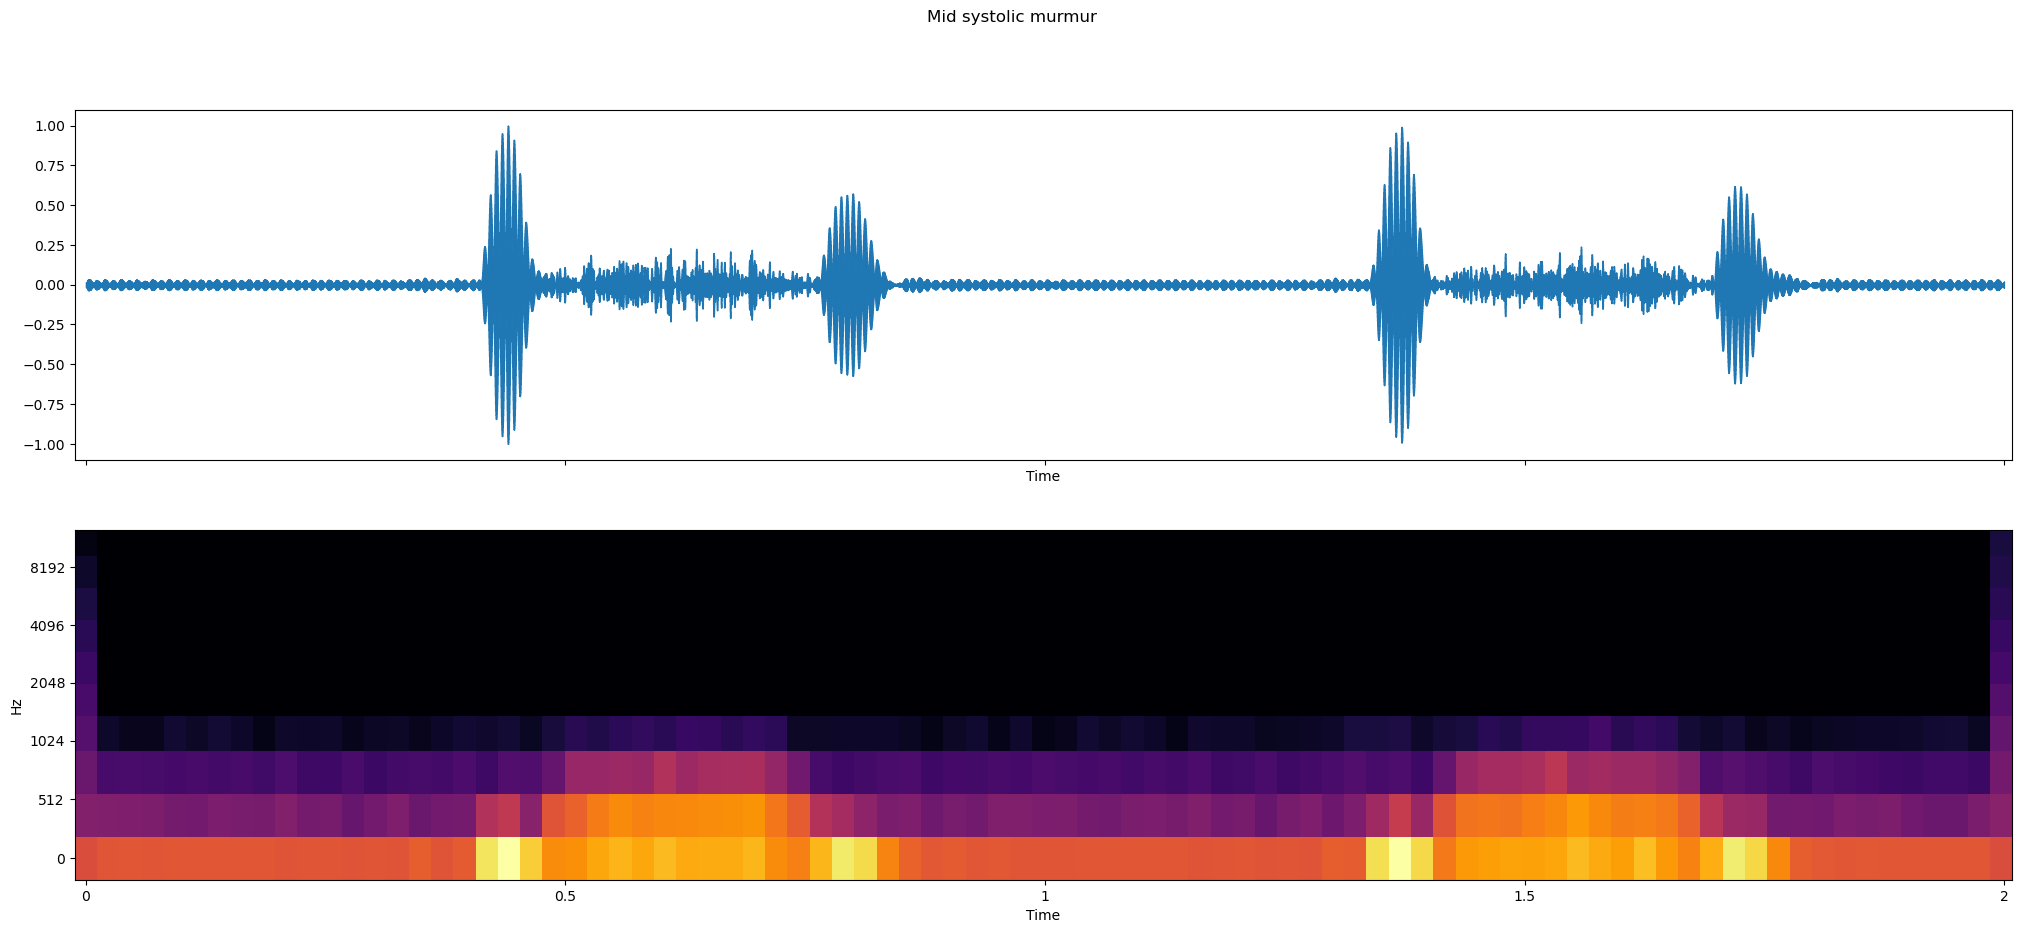

In [31]:
plot_mel_spectrogram(normal, "Normal", sr)
plot_mel_spectrogram(s2_split, "S2 split", sr)
plot_mel_spectrogram(s3, "S3", sr)
plot_mel_spectrogram(mid_syst_murmur, "Mid systolic murmur", sr)

a## MFCC

In [32]:
def plot_mfcc(data, title, rate):
    mfccs = librosa.feature.mfcc(y=data, n_mfcc=13, sr=rate)
    # Note: to compute the derivatives, use: librosa.feature.delta(mfccs, order=nnn)


    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(25, 10))
    librosa.display.waveshow(data, sr= rate, ax=ax1)
    img = librosa.display.specshow(mfccs,
                             sr=rate,
                             hop_length=HOP_LENGTH,
                             x_axis="time",
                             y_axis="mel",
                             cmap='inferno',
                             ax=ax2)
    #fig.colorbar(img, ax=ax2, format='%+2.0f dB')
    fig.suptitle(title)

    plt.show()

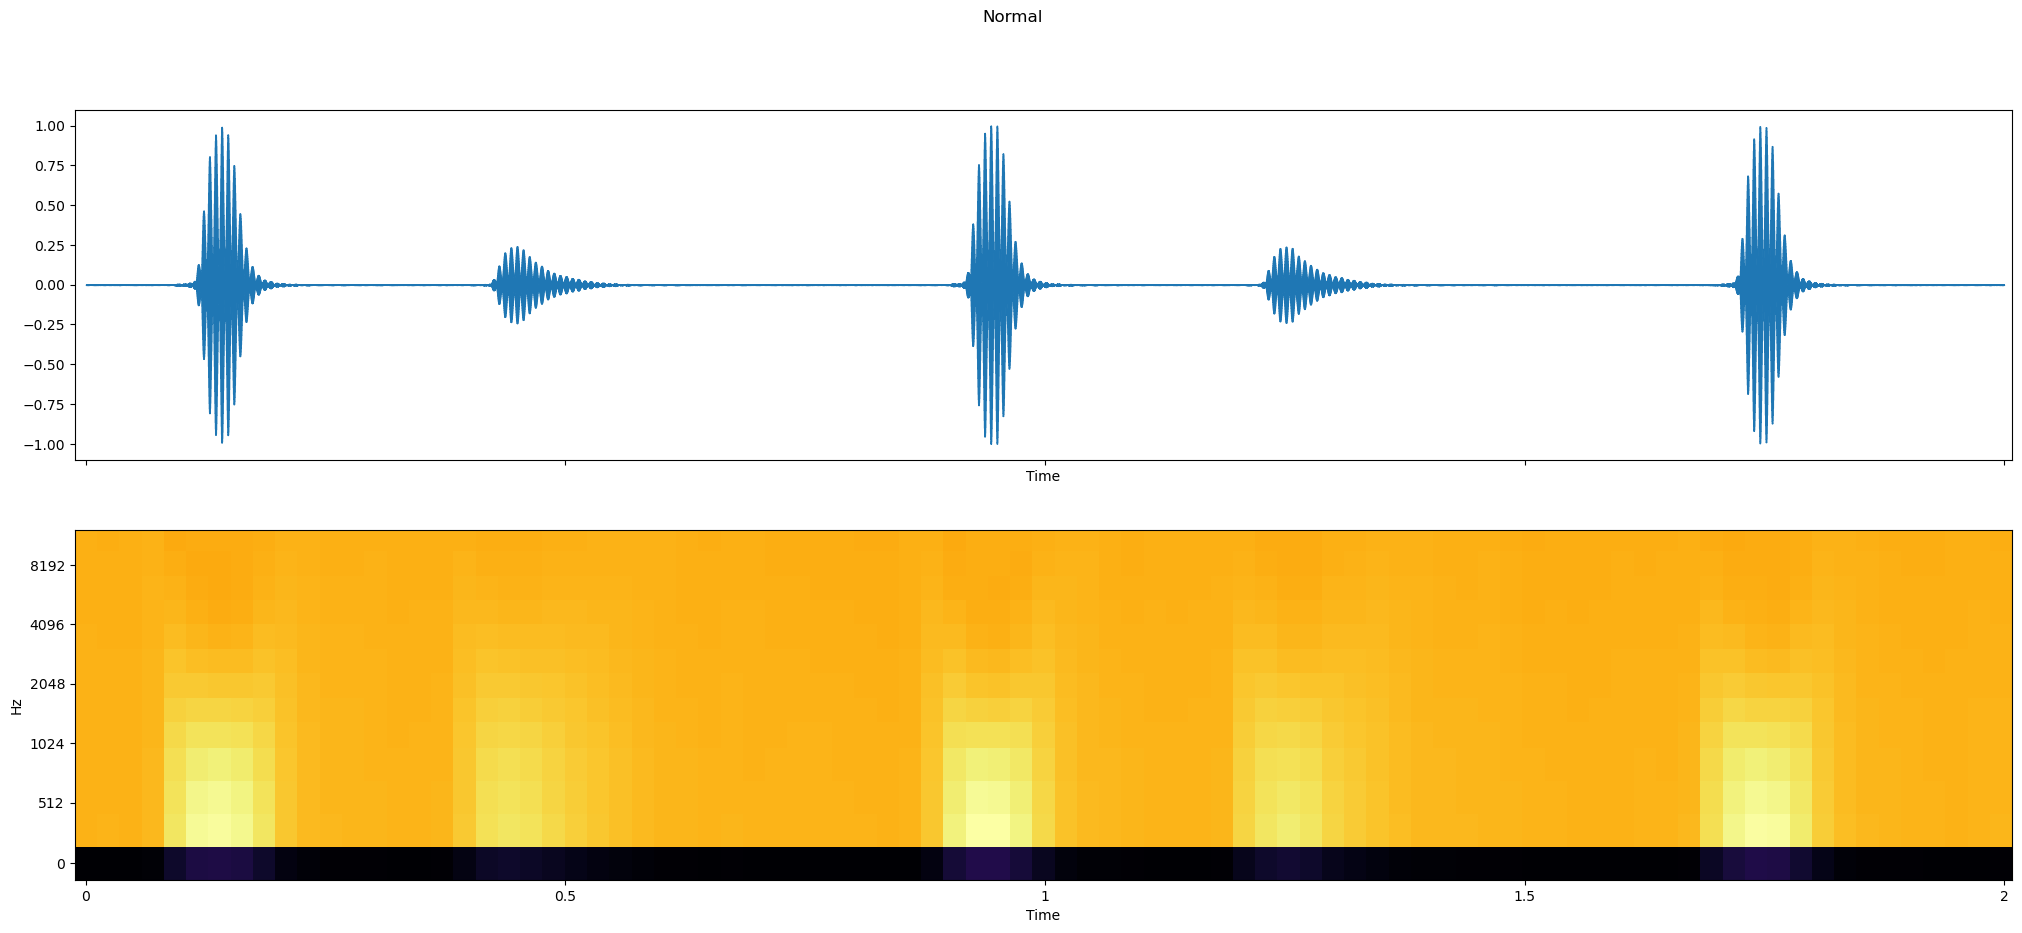

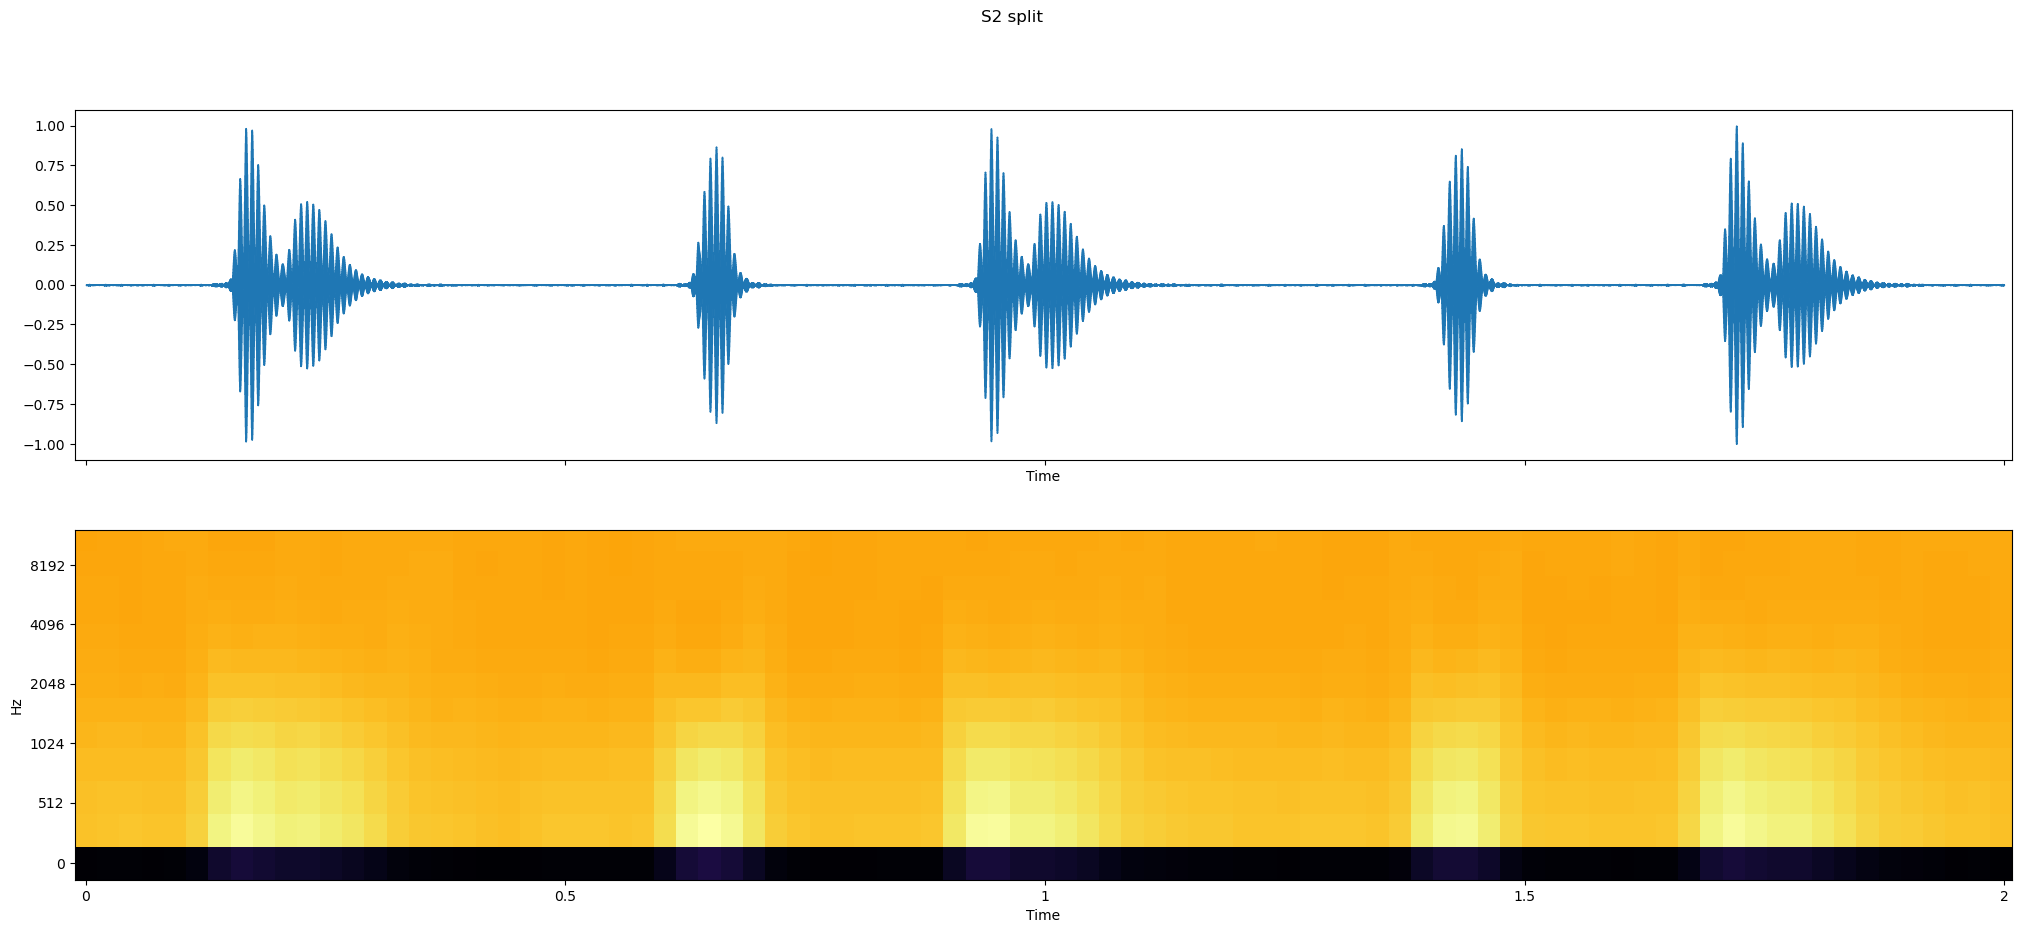

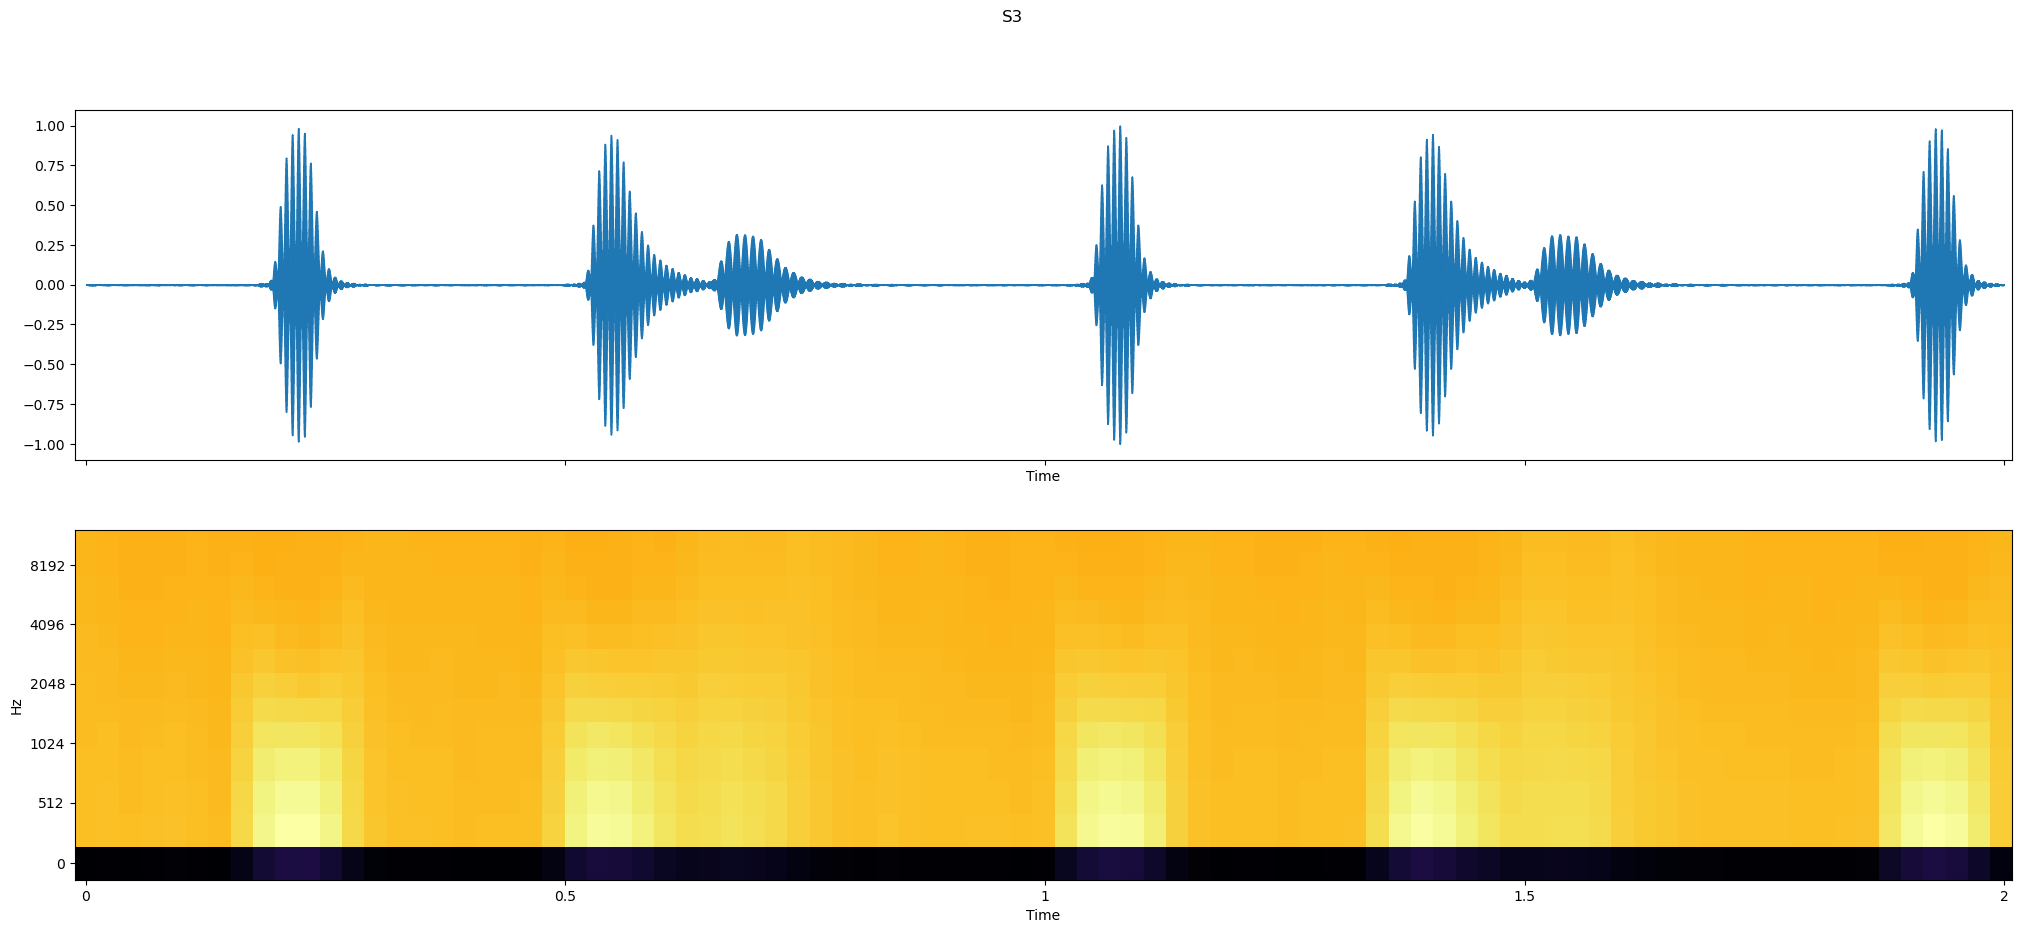

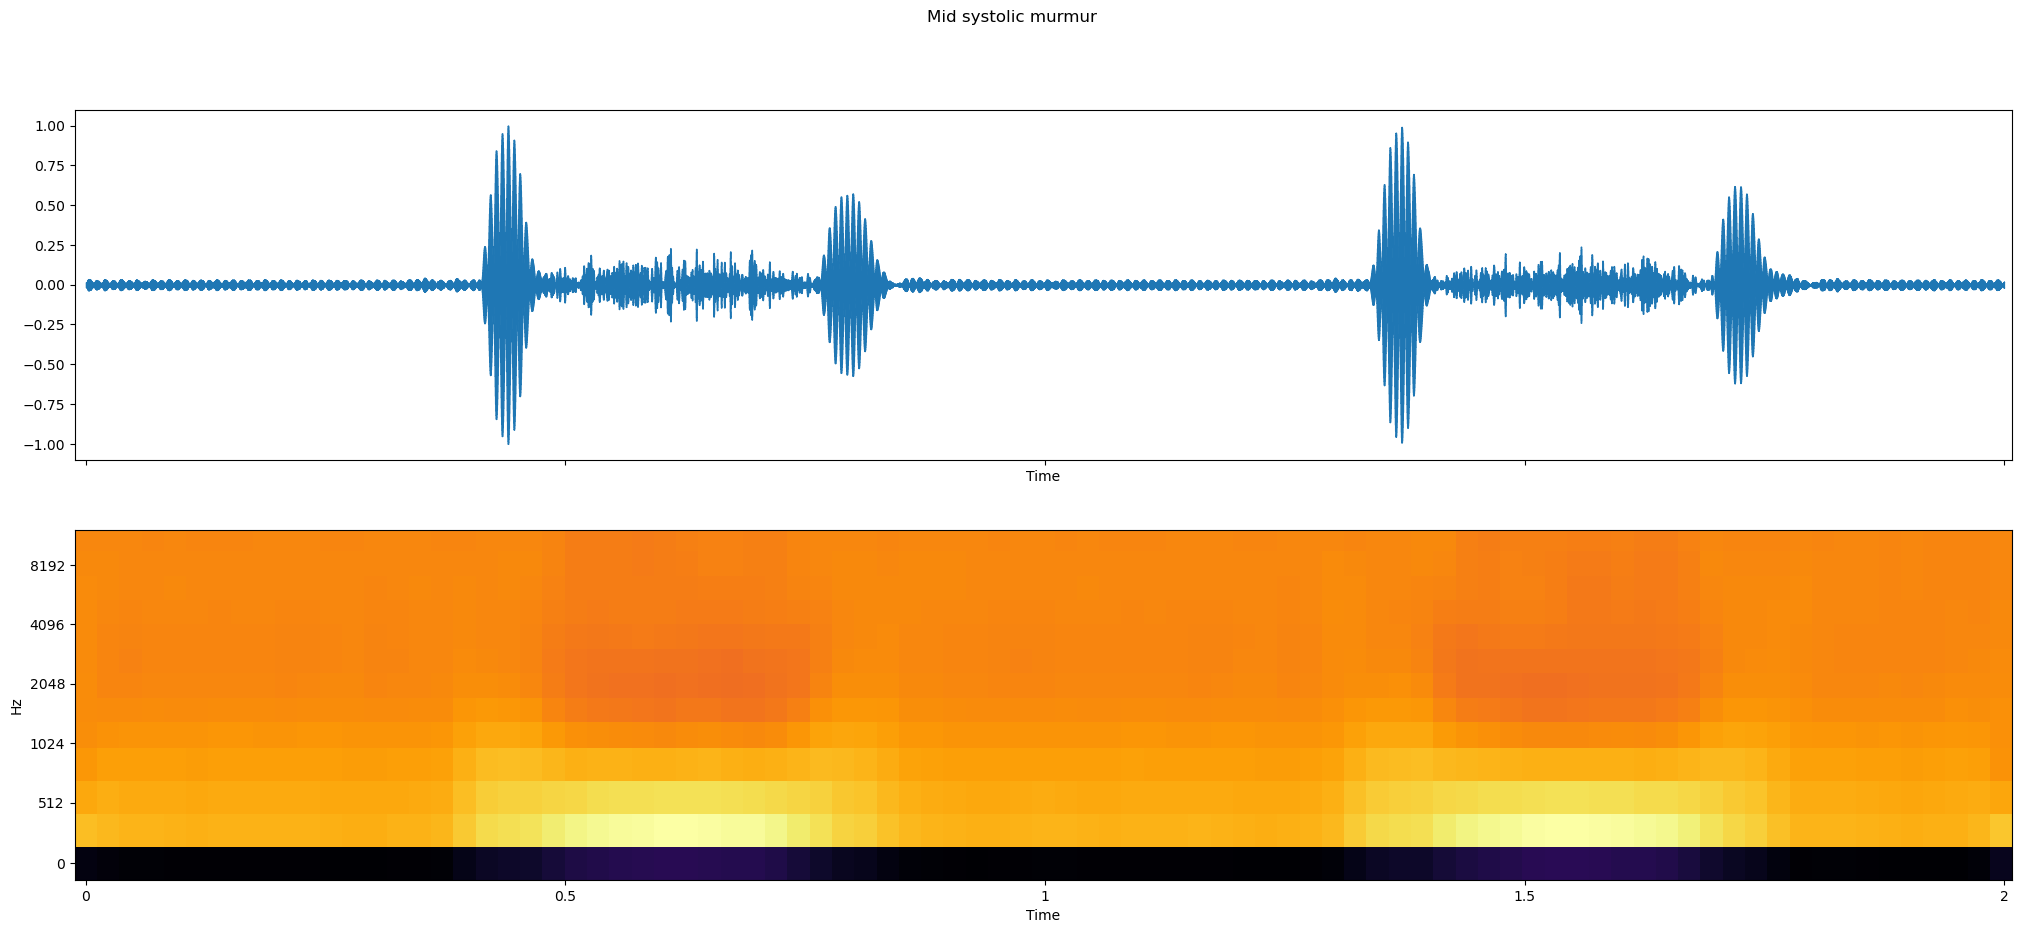

In [33]:
plot_mfcc(normal, "Normal", sr)
plot_mfcc(s2_split, "S2 split", sr)
plot_mfcc(s3, "S3", sr)
plot_mfcc(mid_syst_murmur, "Mid systolic murmur", sr)